In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
first_file  = "cutout_21954"
second_file = "cutout_27321"

In [3]:
f  = h5py.File( "TNG_1_modified.hdf5", "r")
f1 = h5py.File( "TNG_2_modified.hdf5", "r")
f2 = h5py.File("TNG_modified.hdf5", "w")

In [5]:
ff1 = h5py.File( first_file  + ".hdf5" )
ff2 = h5py.File( second_file + ".hdf5" )
pos_com = np.zeros(3)
vel_com = np.zeros(3)

# The coordinates differences between halos' center
for i in range(3):
    pos_com[i] = (np.average( ff2['PartType0/Coordinates'][:, i] ) - np.average( ff1['PartType0/Coordinates'][:, i] ))
    vel_com[i] = (np.average( ff2['PartType0/Velocities'][:, i] ) - np.average( ff1['PartType0/Velocities'][:, i] ))

pos_com, vel_com

(array([-3.59809028,  7.49912338,  9.49129946]),
 array([ -1.35089111,   2.83676147, -14.63479614]))

In [6]:
# Do only once

keys = list(f.keys())

for i, ind in enumerate(keys):
    
    # copy all data
    f.copy(ind, f2)

In [7]:
# Insert makedisk data into the galaxy

# Get groups information
keys = list(f1.keys())

for i, ind in enumerate(keys):

    if ind == "Header":
        continue
    # Get members information
    member = list(f2[ind].keys())

    for j, mem in enumerate(member):
        # delete the original data
        temp = f2[ind][mem][:]
        del f2[ind][mem]

        # store and combine the data
        if   mem == "Coordinates":
            # new coordinates = original data + [x, y, z]
            coord = f1[ind][mem][:] + np.array( pos_com )
            data_combine = np.concatenate((temp, coord), axis=0)

        elif mem == "Velocities":
            # new velocities = original data + [vx, vy, vz]
            vel = f1[ind][mem][:] + np.array( vel_com )
            data_combine = np.concatenate((temp, vel), axis=0)

        elif mem == "ParticleIDs":
            # new particle id = original data + f's total number
            data_combine = np.concatenate((temp, f1[ind][mem][:] + len(temp)), axis=0)

        else:
            data_combine = np.concatenate((temp, f1[ind][mem][:]), axis=0)

        f2[ind].create_dataset(mem, data=data_combine)
    

In [8]:
f['Header'].attrs['NumPart_ThisFile'], f1['Header'].attrs['NumPart_ThisFile']

(array([18, 24,  0,  0,  0,  0], dtype=int32),
 array([19, 18,  0,  0,  0,  0], dtype=int32))

In [9]:
# modify the header particles' information

number_gas = f['Header'].attrs['NumPart_ThisFile'][0] + f1['Header'].attrs['NumPart_ThisFile'][0]
number_dm  = f['Header'].attrs['NumPart_ThisFile'][1] + f1['Header'].attrs['NumPart_ThisFile'][1]

f2['Header'].attrs['NumPart_ThisFile'] = np.array([number_gas, number_dm, 0, 0,     0,     0], dtype='int32')
f2['Header'].attrs['NumPart_Total']    = np.array([number_gas, number_dm, 0, 0,     0,     0], dtype='uint32')

f2['Header'].attrs['NumPart_ThisFile']

array([37, 42,  0,  0,  0,  0], dtype=int32)

In [10]:
f.close()
f1.close()
f2.close()

ff1.close()
ff2.close()

In [11]:
f = h5py.File( "TNG_modified.hdf5", "r+" )

In [12]:
# Calculate the position and the velocity of the center of mass

gas_coord   = f['PartType0']['Coordinates'][:]
dm_coord    = f['PartType1']['Coordinates'][:]

gas_vel     = f['PartType0']['Velocities'][:]
dm_vel      = f['PartType1']['Velocities'][:]

gas_mass    = f['PartType0']['Masses'][:]
dm_mass     = f['PartType1']['Masses'][:]

all_coord   = np.concatenate((gas_coord, dm_coord)  , axis=0)
all_vel     = np.concatenate((gas_vel, dm_vel)      , axis=0)
all_mass    = np.concatenate((gas_mass, dm_mass))

In [13]:
pos_com = np.zeros(3)
vel_com = np.zeros(3)

for i in range(3):
    pos_com[i] = np.sum( all_coord[:, i]*all_mass ) / np.sum( all_mass )
    vel_com[i] = np.sum( all_vel[:, i]*all_mass )   / np.sum( all_mass )

pos_com, vel_com

(array([-1.80060881,  3.29813636,  4.63035478]),
 array([-2.36659829,  0.81168126, -8.27461635]))

In [14]:
# Modify the velocity and the position of the original data

part = [0, 1]

for i in part:
    f['PartType' + str(i) ]['Velocities'][:]    -= vel_com
    f['PartType' + str(i) ]['Coordinates'][:]   -= pos_com

(-20.0, 20.0)

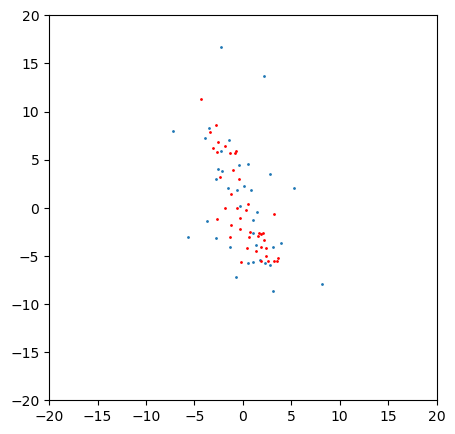

In [15]:
plt.figure(figsize= (5,5))
plt.scatter(f['PartType0/Coordinates'][:,0], f['PartType0/Coordinates'][:,1], s=1)
plt.scatter(f['PartType1/Coordinates'][:,0], f['PartType1/Coordinates'][:,1], s=1, c='r')
plt.ylim(-20, 20)
plt.xlim(-20, 20)

In [16]:
f.close()